In [1]:
import torch
import torch.nn as nn

# Define the heat equation parameter
alpha = 0.01  # Thermal diffusivity

# Define the initial condition (u at t=0)
def initial_condition(x):
    return torch.sin(torch.pi * x)

# Define the boundary conditions (u at x=0 and x=1)
def boundary_condition(t):
    return torch.tensor(0.0)


In [2]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, t, x):
        u = torch.cat([t, x], dim=1)
        return self.layers(u)


In [3]:
# Loss function for the heat equation
def loss_function(model, t, x):
    # Predict the temperature u
    u = model(t, x)
    
    # Compute gradients using autograd
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    
    # Physics-informed loss (u_t = alpha * u_xx)
    physics_loss = u_t - alpha * u_xx
    
    return torch.mean(physics_loss**2)

# Loss function for initial/boundary conditions
def boundary_loss(model, t, x):
    initial_u = model(torch.zeros_like(x), x)  # Initial condition at t=0
    boundary_u_0 = model(t, torch.zeros_like(t))  # Boundary condition at x=0
    boundary_u_1 = model(t, torch.ones_like(t))   # Boundary condition at x=1

    initial_loss = torch.mean((initial_u - initial_condition(x))**2)
    boundary_loss = torch.mean((boundary_u_0 - boundary_condition(t))**2) + torch.mean((boundary_u_1 - boundary_condition(t))**2)
    
    return initial_loss + boundary_loss


In [4]:
# Set up training parameters
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5000

# Generate random points for the domain (t, x)
t_values = torch.rand(100, 1, requires_grad=True)
x_values = torch.rand(100, 1, requires_grad=True)

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Compute the losses
    physics_loss = loss_function(model, t_values, x_values)
    boundary_ic_loss = boundary_loss(model, t_values, x_values)
    
    # Total loss
    total_loss = physics_loss + boundary_ic_loss
    
    # Backpropagation and optimization
    total_loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {total_loss.item()}")


Epoch 0: Loss = 0.31820303201675415
Epoch 500: Loss = 0.0005441087996587157
Epoch 1000: Loss = 0.0024517884012311697
Epoch 1500: Loss = 1.686219547991641e-05
Epoch 2000: Loss = 1.1228886251046788e-05
Epoch 2500: Loss = 8.089467883110046e-06
Epoch 3000: Loss = 6.176265287649585e-06
Epoch 3500: Loss = 4.945505679643247e-06
Epoch 4000: Loss = 3.9629403545404784e-06
Epoch 4500: Loss = 0.0006793676875531673


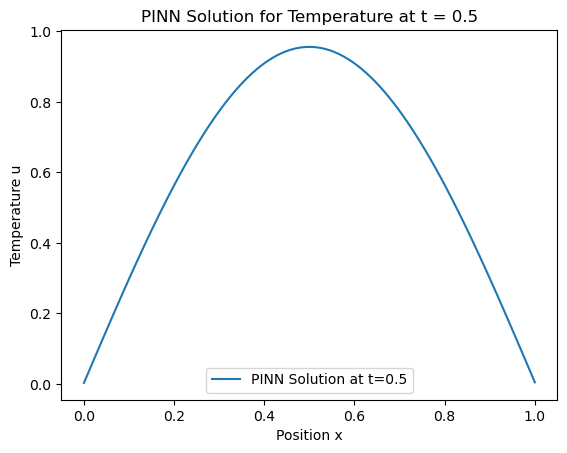

In [5]:
# Set a specific time, e.g., t = 0.5, and evaluate across x
t_fixed = torch.tensor([[0.5]] * 100)  # Fix the time to 0.5 for all positions
x_test = torch.linspace(0, 1, 100).reshape(-1, 1)  # Evaluate across the spatial domain

# Evaluate the PINN at the specific time and spatial points
with torch.no_grad():
    u_fixed_time = model(t_fixed, x_test)

# Convert to NumPy for plotting
u_fixed_time = u_fixed_time.detach().numpy()

# Plot the temperature distribution at t = 0.5
import matplotlib.pyplot as plt
plt.plot(x_test.numpy(), u_fixed_time, label='PINN Solution at t=0.5')
plt.title('PINN Solution for Temperature at t = 0.5')
plt.xlabel('Position x')
plt.ylabel('Temperature u')
plt.legend()
plt.show()


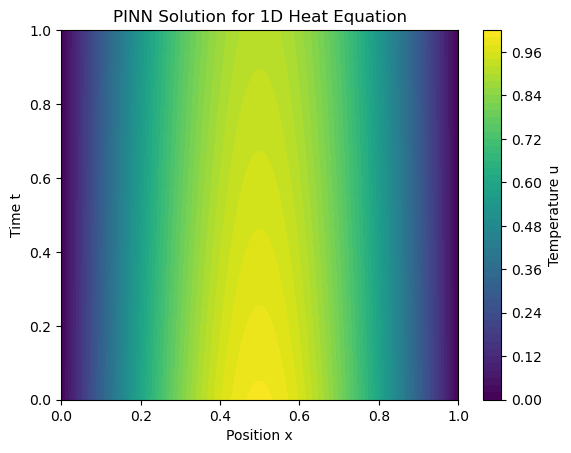

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Generate a grid of points for (t, x) over the entire domain
t_test = torch.linspace(0, 1, 100).reshape(-1, 1)  # Time from 0 to 1
x_test = torch.linspace(0, 1, 100).reshape(-1, 1)  # Space from 0 to 1

# Create a meshgrid of (t, x) values
T, X = np.meshgrid(t_test.numpy(), x_test.numpy())

# Flatten the meshgrid and convert to tensors for model evaluation
t_test_flat = torch.tensor(T.flatten(), dtype=torch.float32).reshape(-1, 1)
x_test_flat = torch.tensor(X.flatten(), dtype=torch.float32).reshape(-1, 1)

# Evaluate the PINN solution for each (t, x) pair
with torch.no_grad():
    u_pinn_flat = model(t_test_flat, x_test_flat).detach().numpy()

# Reshape the result to match the grid shape (100x100)
u_pinn = u_pinn_flat.reshape(T.shape)

# Plot the contour plot for the PINN solution
plt.contourf(X, T, u_pinn, levels=50, cmap='viridis')
plt.colorbar(label='Temperature u')
plt.title('PINN Solution for 1D Heat Equation')
plt.xlabel('Position x')
plt.ylabel('Time t')
plt.show()


### comparison with analytical and numerical pure physics-based solution    

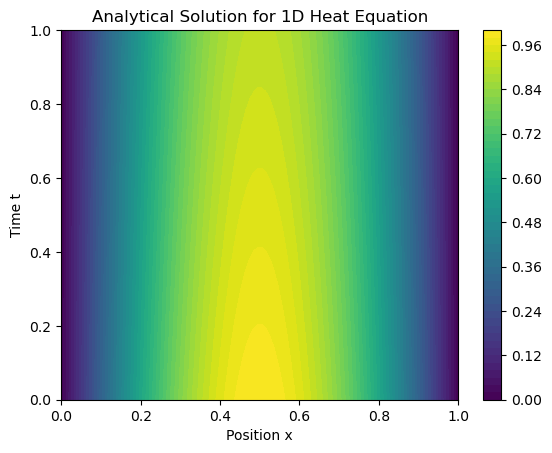

In [7]:
import numpy as np

# Define the analytical solution
def analytical_solution(t, x, alpha):
    return np.exp(-np.pi**2 * alpha * t) * np.sin(np.pi * x)

# Generate a grid of points for t and x
t_test_analytical = np.linspace(0, 1, 100)
x_test_analytical = np.linspace(0, 1, 100)

# Calculate the analytical solution at these points
T, X = np.meshgrid(t_test_analytical, x_test_analytical)
u_analytical = analytical_solution(T, X, alpha)

# Plot the analytical solution
import matplotlib.pyplot as plt
plt.contourf(X, T, u_analytical, levels=50, cmap='viridis')
plt.colorbar()
plt.title('Analytical Solution for 1D Heat Equation')
plt.xlabel('Position x')
plt.ylabel('Time t')
plt.show()


# comparison with finite differences

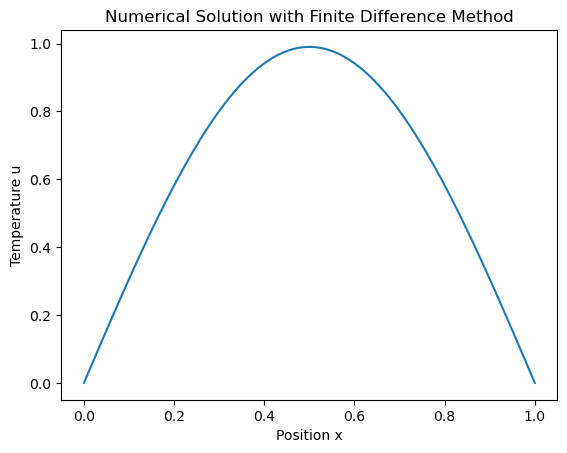

In [8]:
# Finite Difference Method (FDM) to solve 1D Heat Equation

# Parameters
nx = 100  # Number of spatial grid points
nt = 100  # Number of time steps
dx = 1.0 / (nx - 1)  # Spatial step size
dt = 0.001  # Time step size
alpha = 0.01  # Thermal diffusivity

# Stability condition for explicit method: dt <= dx^2 / (2*alpha)
assert dt <= dx**2 / (2 * alpha), "Time step is too large for stability!"

# Initial condition
u_fd = np.sin(np.pi * np.linspace(0, 1, nx))

# Boundary conditions
u_fd[0] = u_fd[-1] = 0

# Time evolution
for n in range(nt):
    u_fd_new = u_fd.copy()
    for i in range(1, nx-1):
        u_fd_new[i] = u_fd[i] + alpha * dt / dx**2 * (u_fd[i+1] - 2 * u_fd[i] + u_fd[i-1])
    u_fd = u_fd_new.copy()

# Plot the numerical solution
plt.plot(np.linspace(0, 1, nx), u_fd, label='Finite Difference Solution')
plt.title('Numerical Solution with Finite Difference Method')
plt.xlabel('Position x')
plt.ylabel('Temperature u')
plt.show()


# Comparison: 

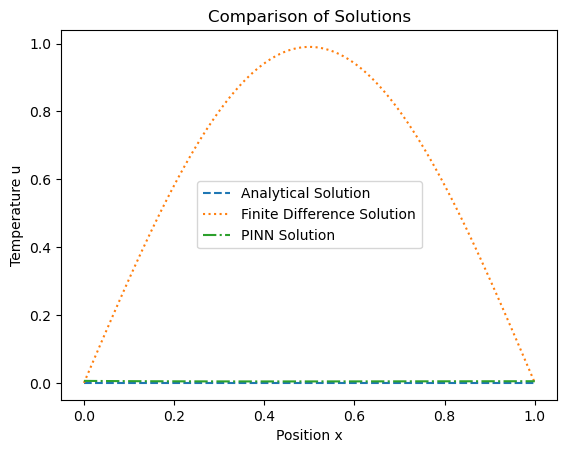

In [9]:
# Get the PINN solution at the same points used for the analytical and numerical solutions
with torch.no_grad():
    t_test_tensor = torch.tensor(T.flatten(), dtype=torch.float32).reshape(-1, 1)
    x_test_tensor = torch.tensor(X.flatten(), dtype=torch.float32).reshape(-1, 1)
    u_pinn = model(t_test_tensor, x_test_tensor).detach().numpy().reshape(T.shape)

# Plot all three solutions for comparison
plt.plot(x_test_analytical, u_analytical[-1, :], label='Analytical Solution', linestyle='--')
plt.plot(x_test_analytical, u_fd, label='Finite Difference Solution', linestyle=':')
plt.plot(x_test_analytical, u_pinn[-1, :], label='PINN Solution', linestyle='-.')

plt.title('Comparison of Solutions')
plt.xlabel('Position x')
plt.ylabel('Temperature u')
plt.legend()
plt.show()


In [10]:
# Mean squared error (MSE) between PINN and analytical solution
mse_pinn_analytical = np.mean((u_pinn - u_analytical)**2)
print(f'MSE between PINN and analytical solution: {mse_pinn_analytical}')

# MSE between Finite Difference and analytical solution
mse_fd_analytical = np.mean((u_fd - u_analytical[-1, :])**2)
print(f'MSE between Finite Difference and analytical solution: {mse_fd_analytical}')


MSE between PINN and analytical solution: 1.9040785763373774e-05
MSE between Finite Difference and analytical solution: 0.48532522643140247
